In [229]:
import numpy as np
from solver import freq_top_opt_2D
import matplotlib.pyplot as plt
%matplotlib inline
verbose = False
if not verbose:
    import warnings
    warnings.filterwarnings("ignore")
from plot import init_plot_params
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [230]:
res  = 0.5 # inverse of resolution
scaling = res*1e-6 # the scale applied to the physical problem
nElx =  int(14/res) # the number of elements in the X axis
nEly =  int(4/res) # the number of elements in the Y axis
nodesX = nElx + 1
nodesY = nEly + 1
print("Number of elements in X: ", nElx)
print("Number of elements in Y: ", nEly)
print("Total number of elements: ", nEly*nElx)

Number of elements in X:  28
Number of elements in Y:  8
Total number of elements:  224


In [231]:
n_metal = 3.1477 # refractive index for TiN
k_r =  5.8429  # exctinction coefficient for TiN
n_wg  = np.sqrt(15.054) # refractive index of the waveguide
n_clad = np.sqrt(4.2) # refractive index of cladding

h_core = 1e-6 / scaling
w_core = 10e-6 / scaling 
print(h_core, w_core)

2.0 20.000000000000004


In [232]:
wl = 1.55 / res  # value for the wavelentgth, i.e. 1.55 um.
k = 2 * np.pi / (wl * scaling) # value of the wavevector
delta = 3.8121 # Effective refractive index from COMSOL
dz = 200E-6 # also works fine 900E-6
deltaT = 3.813
#elta_T_pi = (1/2E-4) * 0.5*(wl* scaling)/dz
#print("T_pi: ", delta_T_pi)
#change_delta = delta_T_pi * 2E-4
#deltaT = delta +  change_delta # previous: 3.8624
#print("Initial effective index: ", delta)
#print("Heated effective index: ", deltaT)

In [233]:
fR = 5 # value for the filtering radius   
maxItr = 1 # number of iterations performed by the optimizer
alg = "MMA" # algorithm: Method of  Moving Asymptotes
eta = 0.5 # parameter that controls threshold value.
beta = 15 #2.25 * 5 # parameter that controls threshold sharpness.
alpha = 5 #2.25 
FOM_type = "linear"
tol = 1e-3

In [234]:
dVini_Omega_1 =0.0# intial value of design parameters in Omega_1
dVini_Omega_3 = 0.0 # intial value of design parameters in Omega_3
nEl_Omega_3 = 1

In [235]:
nEly_heat = nEly
nElx_heat = nElx
nEly_EM = nEly
nElx_EM = nElx


volume1  = np.zeros((nEly_heat, nElx_heat))
volume2  = np.zeros((nEly_heat, nElx_heat))
volume4  = np.zeros((nEly_heat, nElx_heat))
volume5  = np.zeros((nEly_heat, nElx_heat))


volume3 = np.zeros((nEly_heat, nElx_heat))

h_domain = 4E-6 / scaling#10e-6
#alpha = 0.0

w_non_design = w_core #+ alpha * (h_domain-h_core)
h_non_design = h_core #+ alpha * (h_domain-h_core)

w_design_limit = nElx_EM 
h_design_limit = nEly_EM


volume1 [nEly_heat//2 - int(0.5*h_core) : nEly_heat//2 + int(0.5*h_core),nElx_heat//2 - int(0.5*w_core) : nElx_heat//2 + int(0.5*w_core)] = 1 # waveguide region
volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)] = 1
volume5 [nEly_heat//2 - h_design_limit//2 :nEly_heat//2 + h_design_limit//2 ,nElx_heat//2 - w_design_limit//2 : nElx_heat//2 + w_design_limit//2] = 1 
volume5 = volume5 - volume4

print(np.shape(volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)]))
print(np.shape(volume5 [nEly_heat//2 - h_design_limit//2 :nEly_heat//2 + h_design_limit//2 ,nElx_heat//2 - w_design_limit//2 : nElx_heat//2 + w_design_limit//2]))


indexes_design_limit = np.array(np.where(volume5<1))
volume4 [indexes_design_limit[0,:], indexes_design_limit[1,:]] = 1

volume3 [(nEly_heat)//2 - int(0.5*h_core) : (nEly_heat)//2 + int(0.5*h_core),(nElx_heat)//2 - int(0.5*w_core) : (nElx_heat)//2 + int(0.5*w_core)] = 1 # waveguide region
print((nEly_heat)//2 - int(0.5*h_core) - (nEly_heat)//2 - int(0.5*h_core))
print((nElx_heat)//2 - int(0.5*w_core) - (nElx_heat)//2 - int(0.5*w_core))

indexes_design_region_heat = np.array(np.where(volume5 == 1))
indexes_RHS = np.array(np.where(volume3 < 1))

indexes_wg_heat = np.array(np.where(volume3 == 1))


volume2 [nEly_heat//2 - int(0.5*h_core)-nEl_Omega_3:nEly_heat//2 + int(0.5*h_core)+nEl_Omega_3,nElx_heat//2 - int(0.5*w_core)-nEl_Omega_3:nElx_heat//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating_heat = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint
indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_constraint]= dVini_Omega_3

h_metal = 0.25E-6 / scaling
w_metal = 4E-6 / scaling
volume4 [:, :] = 0.0
volume4 [nEly//2 + int(0.5*h_core) : nEly//2 + int(0.5*h_core) + int(h_metal) , nElx//2 - int(0.5*w_core) : nElx//2 - int(0.5*w_core) + int(w_metal)] = 1 # metal region
indexes_metal = np.array(np.where(volume4 > 0.5))

from wg_index import calc_index_constraint

indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)
indexes_metal_heater = (calc_index_constraint(indexes_design_region_heat, indexes_metal)).astype(int)
dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_metal_heater]= 1.0

random = True
if random:
   dVini = np.random.rand(len(dVini))

volume1_heat = volume1


(2, 20)
(8, 28)
-2
-20


In [236]:
indexes_design_region_EM = indexes_design_region_heat
indexes_wg_EM = indexes_wg_heat
indexes_heating_EM = indexes_heating_heat

In [237]:
vol_cons_val = 0.5
heat_cons_val =  0.0

In [238]:
RHS_heater = indexes_wg_heat
val_heater =  20E-3 * np.ones_like(indexes_design_region_heat)
dz = 200e-6
k_wg = 148 
k_clad = 1.38 
k_metal = 28

In [239]:
L = dz

phase_shift = (deltaT-delta)*(2*np.pi*L)/(wl*scaling)
print("Phase-shift: ", str(phase_shift)+"  rad")

Phase-shift:  0.7296602292209547  rad


In [240]:
solver = freq_top_opt_2D( nElx_EM, 
                          nEly_EM,
                          nElx_heat, 
                          nEly_heat,
                          dVini,
                          w_core,
                          h_core,
                          n_metal,
                          k_r,
                          n_wg,
                          n_clad,
                          wl,
                          delta,
                          deltaT,  
                          fR,
                          eta,
                          beta,
                          scaling,
                          vol_cons_val,
                          FOM_type,
                          indexes_wg_EM,
                          indexes_wg_heat,
                          indexes_design_region_EM,
                          indexes_design_region_heat,
                          heat_cons_val,
                          indexes_heating_EM,
                          indexes_heating_heat,
                          continuation_scheme= True,
                          heating_constraint= False,
                          volume_constraint= False,
                          eliminate_excitation= False,
                          dz=dz,
                          alpha = alpha,
                          k_wg = k_wg,
                          k_clad = k_clad,
                          k_metal = k_metal,
                          debug=False
                        )

---------------------------------------------------
Solving for the unheated device ...
---------------------------------------------------


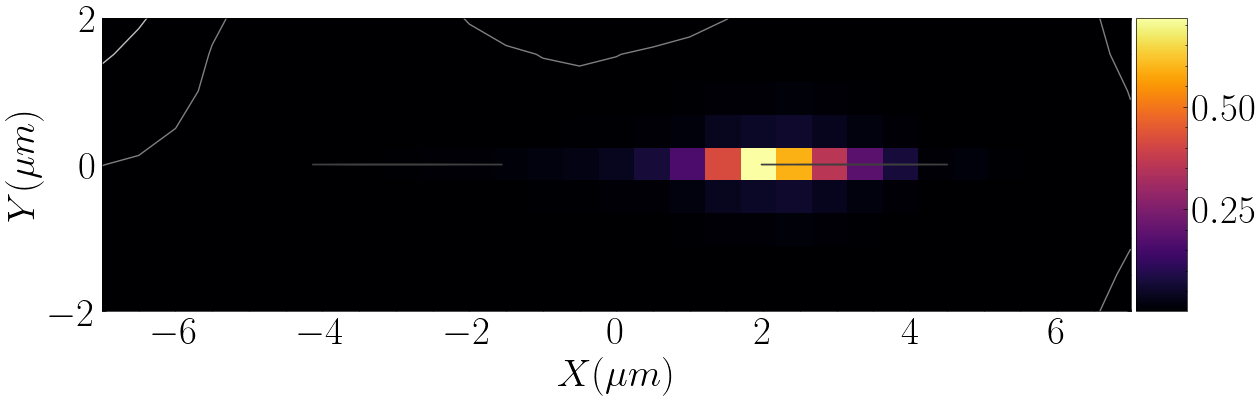

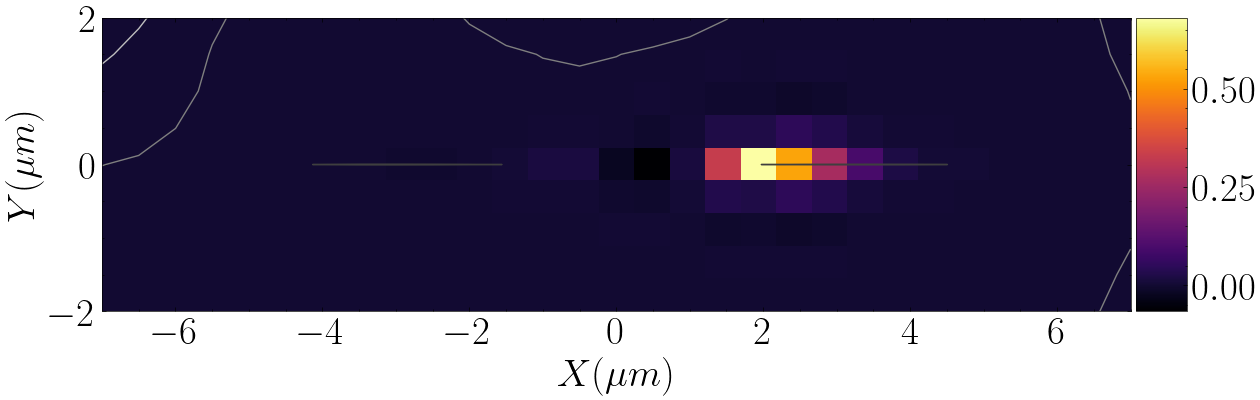

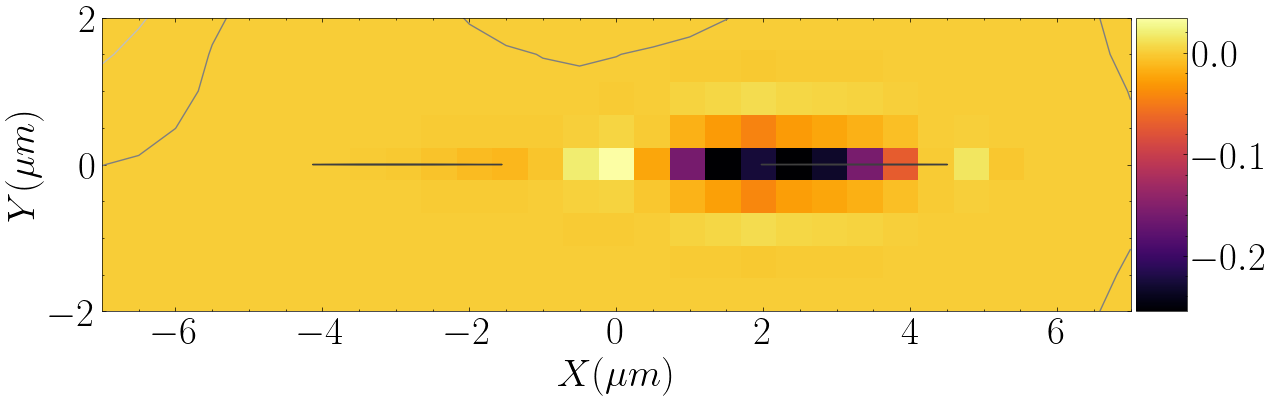

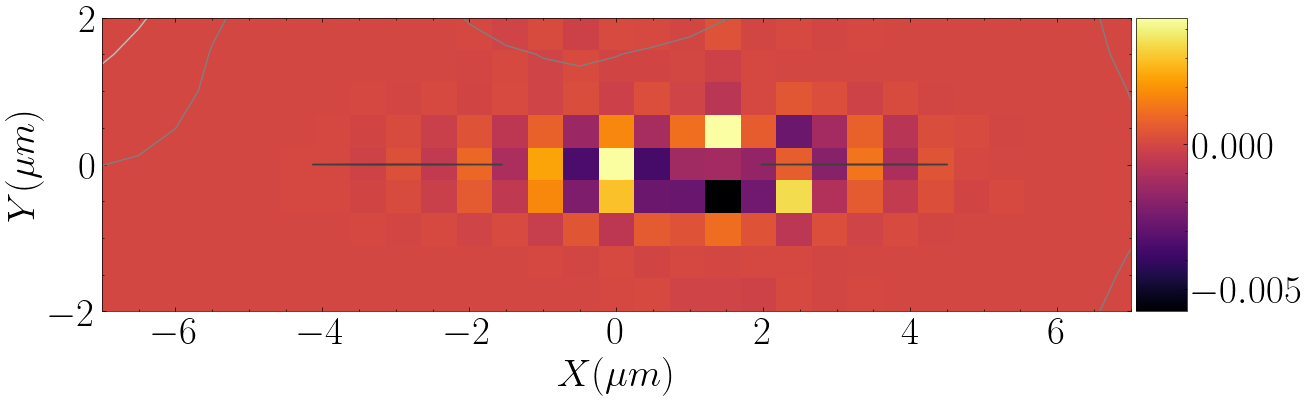

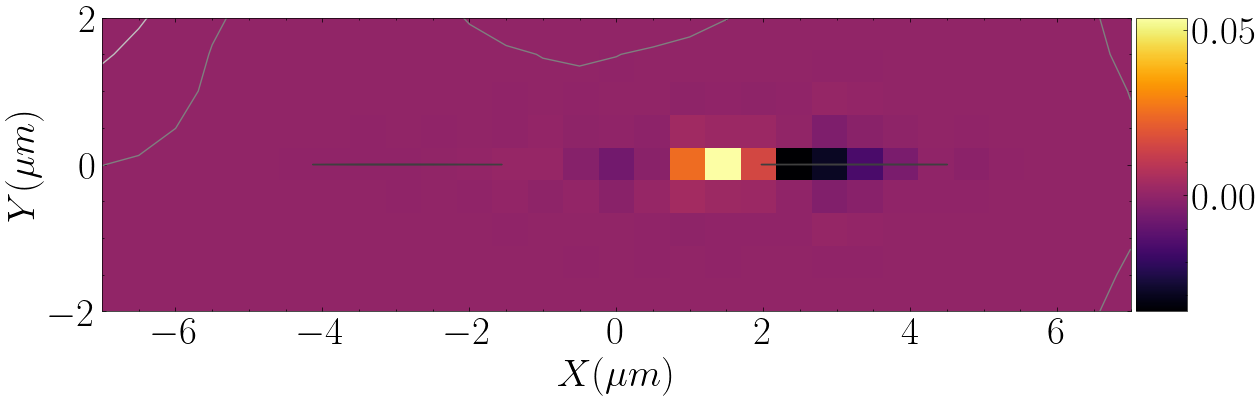

EM FOM, for unheated device:  0.004755071132815393
---------------------------------------------------
Solving for the heat propagation...
---------------------------------------------------


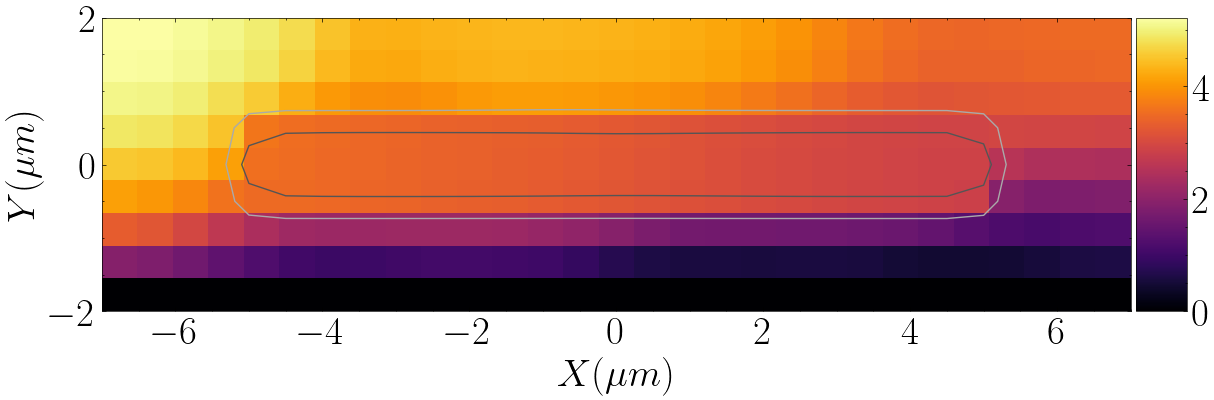

---------------------------------------------------
Solving for the heated device ...
---------------------------------------------------


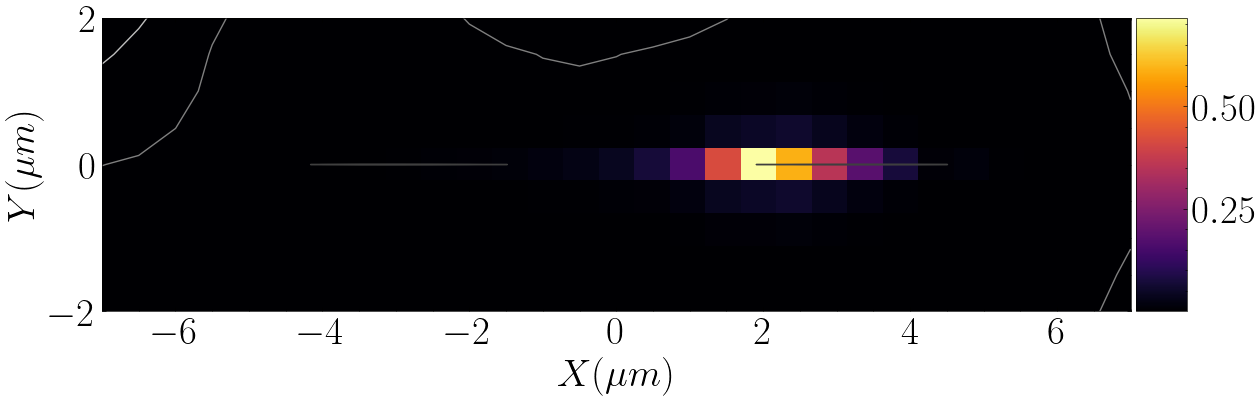

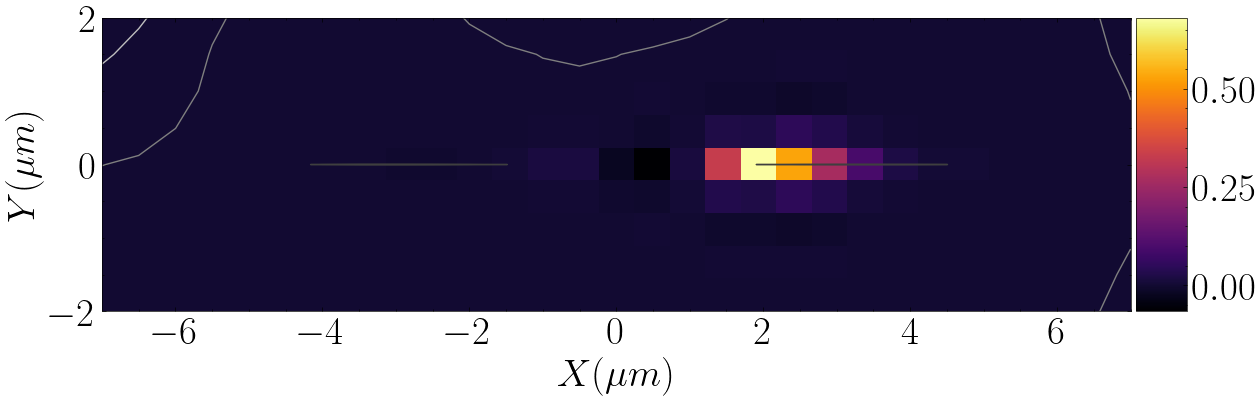

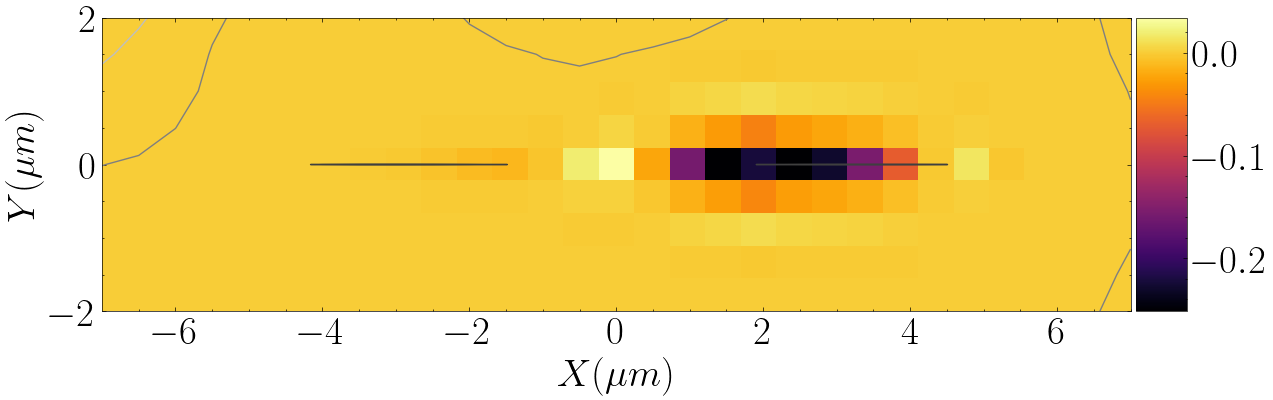

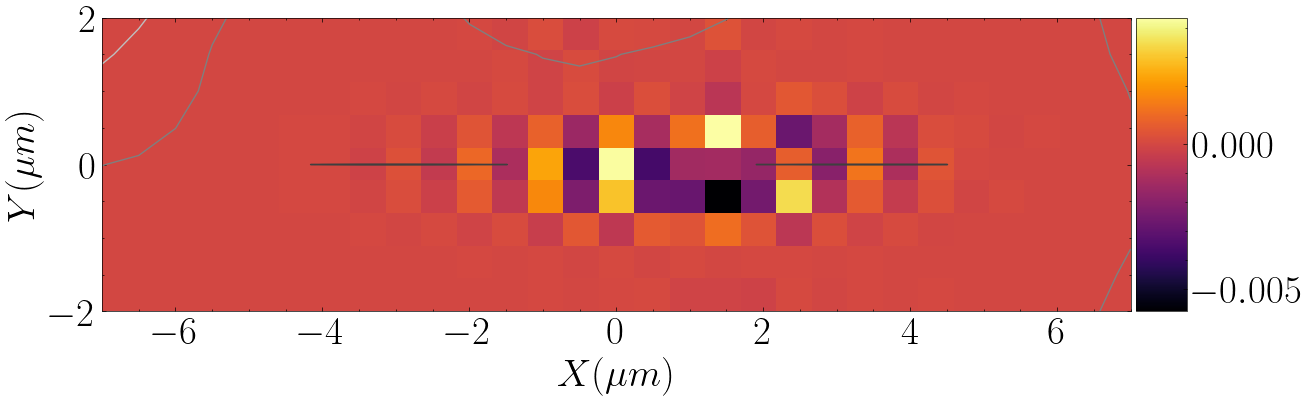

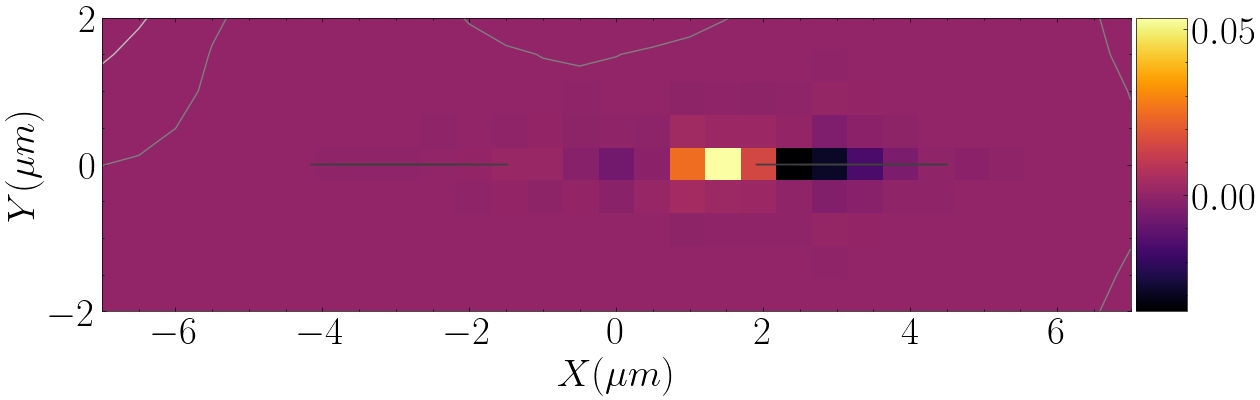

EM FOM, for heated device:  0.0047153049396348335


In [241]:
component = 0 # 0=E, 1=H
node_RHS =  int(component*nodesX*nodesY + 0.5*nodesX*nodesY+0.1428*nodesX)
idx_RHS_EM = np.array([node_RHS, node_RHS]).astype(int) #np.array([node_RHS]).astype(int) #np.array([node_RHS, node_RHS-0.5*nodesX+1]).astype(int)
val_RHS_EM = np.array([0.5E-11*(2.75+1.25j), 0.5E-11*(2.75+1.25j)]) * 10 * 4 # np.array([0.5E-5*(1+0.5E-4j)]) * 10 #np.array([0.5E-5*(1+0.5E-4j), -0.5E-5*(1+0.5E-4j)]) * 10
#dVs = np.load("fd_check.npy")

solver.solve_coupled(dVini, solver='RHS', idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater)

FOM partial:  0.004755071132815393
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM1:  -2.3228429819109753
FOM partial:  0.0047153049396348335
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM2:  -2.326490216114696
----------------------------------------------
Total optimization time: 0 min 1 s
----------------------------------------------


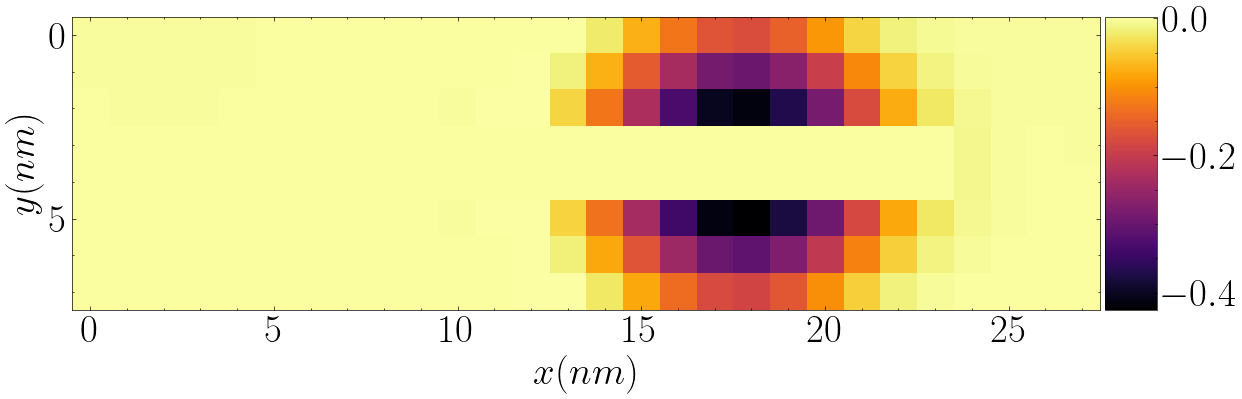

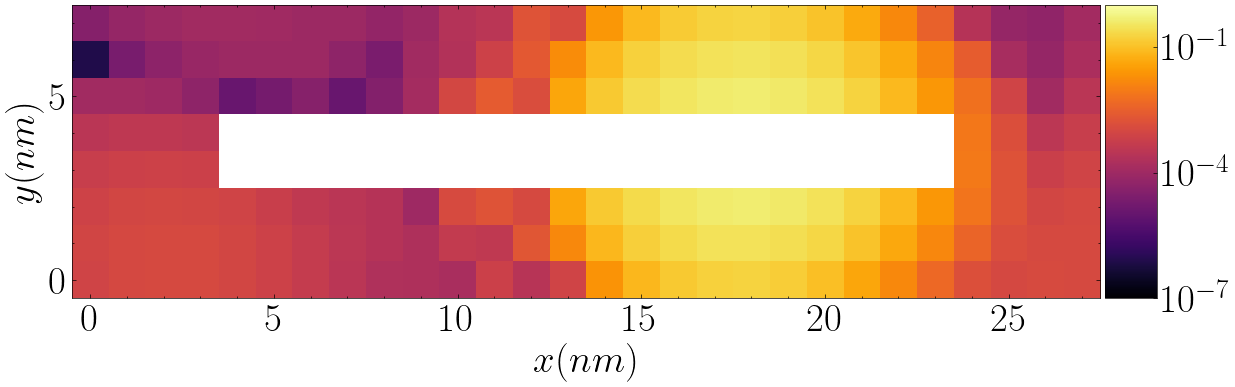

In [242]:
dVs = solver.optimize_coupled_minmax(maxItr, tol, alg, idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater)
sens = solver.plot_sensitivities_coupled() 

def plot_sens(sens, vmin, vmax): 
    #init_plot_params(28)
    from matplotlib.colors import LogNorm

    fig, ax = plt.subplots(figsize=(14,10))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    region = np.zeros((nEly, nElx))
    region [indexes_design_region_EM[0,:], indexes_design_region_EM[1,:]] = np.reshape(sens, np.shape(region [indexes_design_region_EM[0,:], indexes_design_region_EM[1,:]]))

    im = ax.imshow(np.abs(np.real(region)), cmap='inferno', origin="lower", norm=LogNorm(vmin=vmin, vmax=vmax))#, vmax=0.0025, vmin=-0.001)
    #ax.contour(np.real(dis.eps), levels=2, cmap='binary', linewidth=2, alpha=1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_xlabel('$x (nm)$')
    ax.set_ylabel('$y (nm)$')

    plt.show()

plot_sens(np.abs(sens), vmin=1E-7, vmax=1E-0)

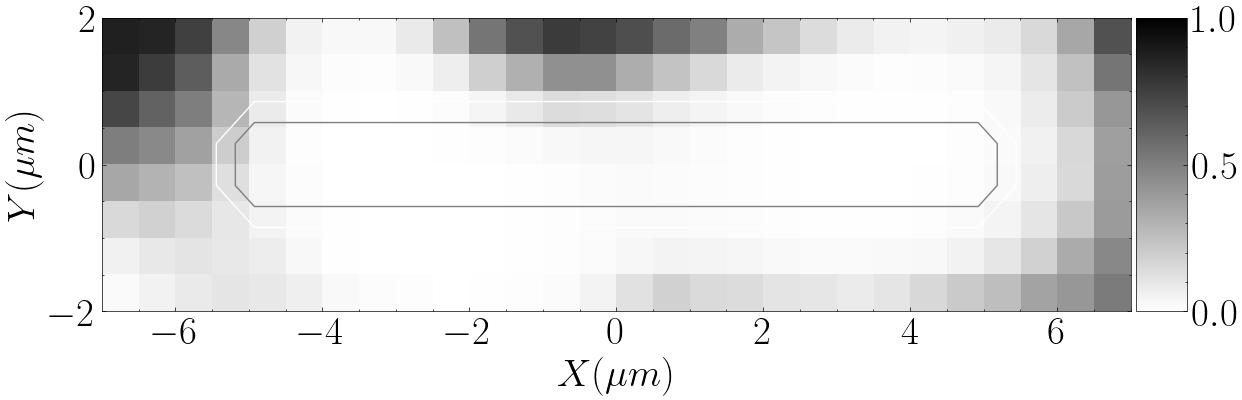

In [243]:
solver.plot_material_interpolation()

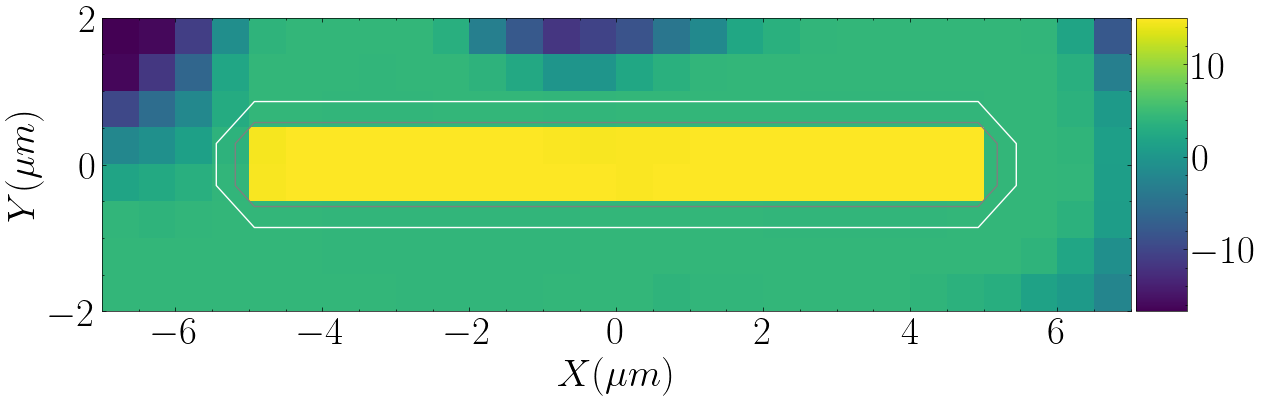

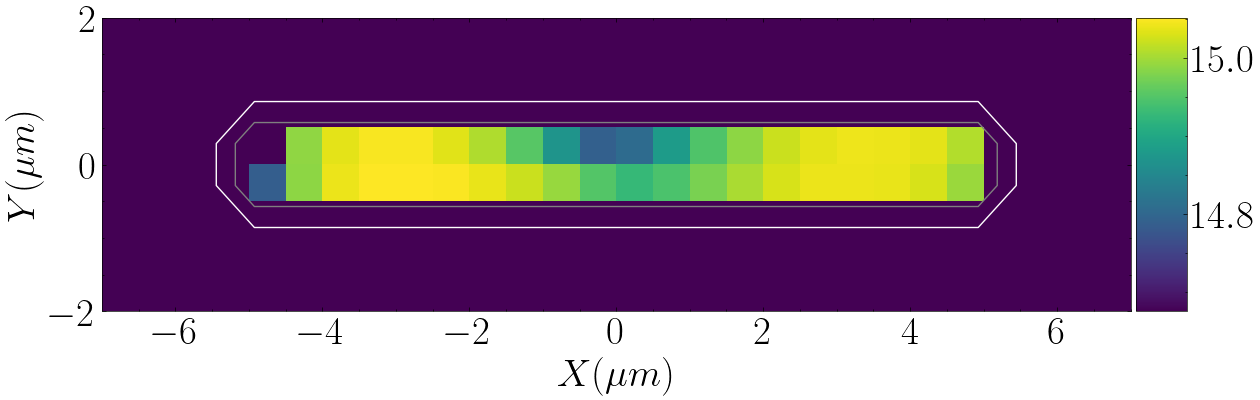

In [244]:
solver.plot_permittivity()

FOM partial:  0.0047153049396348335
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304930905838
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.00471530492881366
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304927883917
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304928265204
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304929829887
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304932164837
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.004715304934498448
Elapsed time in iteration: 0 min 0 s
----------------------------------------------
FOM partial:  0.0047153049363576685
Elapsed time

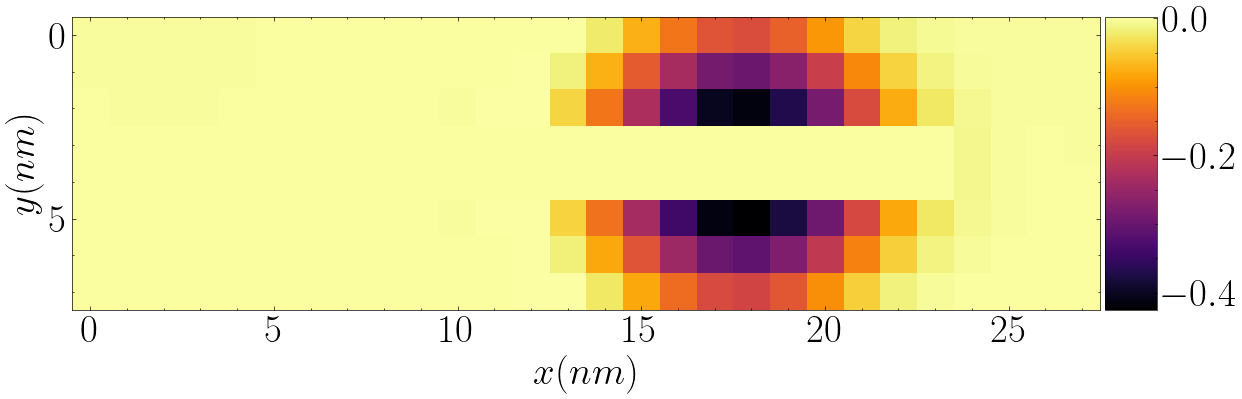

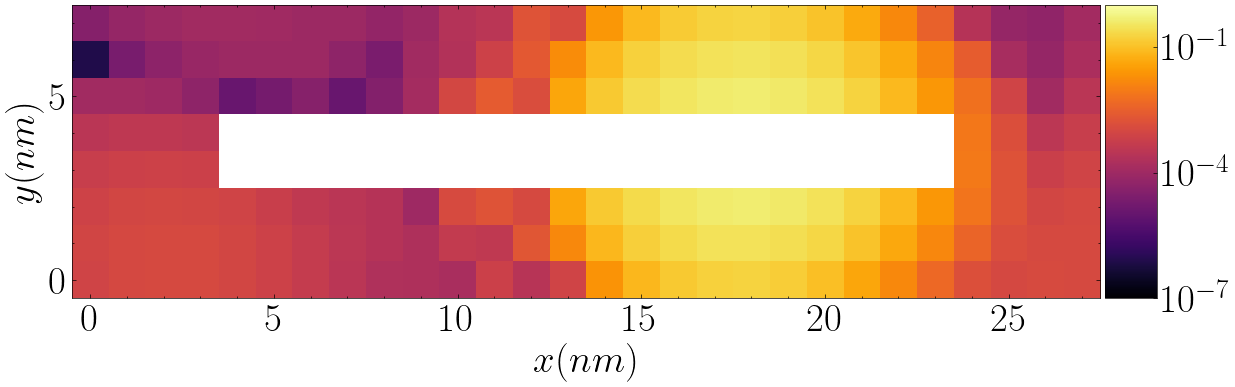

In [245]:
sens_fd = solver.sens_check_coupled (dVs, idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater, delta_dV = 1e-6)
np.save("sens_fd_coupled_copy.npy", sens_fd)
sens_fd = np.load("sens_fd_coupled_copy.npy")

sens2 = np.zeros((nEly, nElx))

sens2[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = sens_fd  #/ np.max(sens_fd)

plot_sens(np.abs(sens_fd), vmin=1E-7, vmax=1E0)

0.0025529729441586824


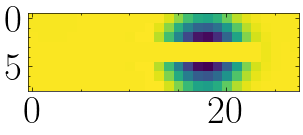

In [246]:
plt.imshow(sens2)
print(np.max(sens2))
plt.show()

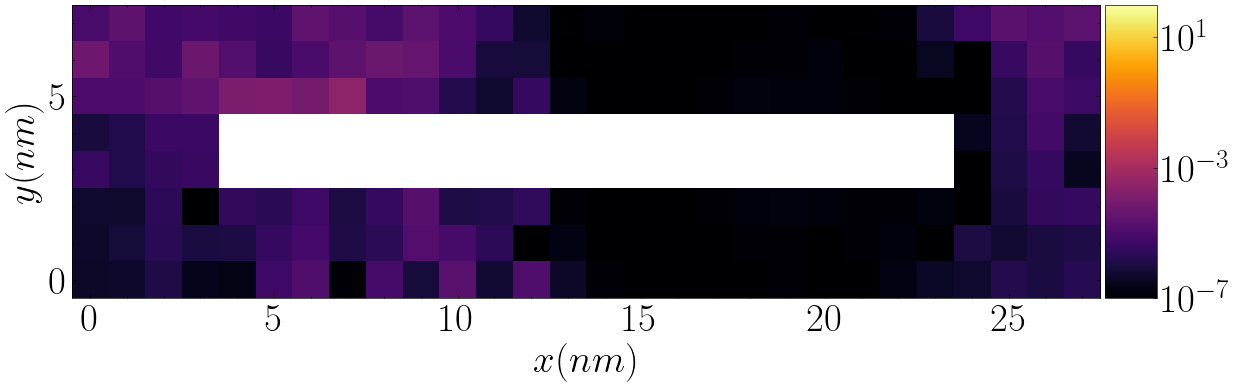

7.141035596180956e-08
-1.1221507528746955e-08
0.002552971480337239
0.0025529729441586824


In [247]:
sens1 = np.zeros((nEly, nElx))
sens2 = np.zeros((nEly, nElx))
sens1[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = sens #- 0.002058440842513084 

#/ np.max(sens)
sens2[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = sens_fd  #/ np.max(sens_fd)

rel_err = np.zeros((nEly, nElx))
abs_err = np.zeros((nEly, nElx))

rel_err[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = (np.abs(np.real(sens1-sens2))/np.abs(np.real(sens1))) [indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] #(np.abs(sens1-sens2)/abs(sens1)) [indexes_design_region[0,:], indexes_design_region[1,:]]
abs_err[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = (np.real(sens1-sens2)) [indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] #(np.abs(sens1-sens2)/abs(sens1)) [indexes_design_region[0,:], indexes_design_region[1,:]]

#plt.imshow(sens2)
#print(np.max(sens2))
#print(np.min(sens2))
abs_error = (np.abs(np.real(sens-sens_fd)))
rel_error = (np.abs(np.real(sens-sens_fd)/np.abs(sens)))
plot_sens(np.abs(rel_error), vmin=1E-7, vmax=1E2)
print(np.max(abs_err))
#print(np.mean(abs_err))
print(np.min(abs_err))
#print(np.max(rel_err))
#print(np.mean(rel_err))
#print(np.min(rel_err))

#plt.imshow(rel_err)
#print(np.mean(rel_err))
#print(np.min(rel_err))
print(np.max(sens1))
print(np.max(sens2))
plt.show()

In [248]:
print(np.shape(indexes_design_region_heat[0,:]))
from scipy.signal import argrelextrema

maxima_index = argrelextrema(np.array(sens), np.greater)
print(maxima_index)
idx = 46#421
idx_1 = 49#421
idx_2 = 64#420
idx_3 = 91#419
idx_4 = 110#422
idx_5 = 139#423
idx_6 = 161#418

print("-----------------------------------------------------")
print("INDEX 1:", idx)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx]))
print("Value of finite-difference sensitivity: ",sens_fd[idx])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx], indexes_design_region_heat[1,idx]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx], indexes_design_region_heat[1,idx]])
print("-----------------------------------------------------")
print("INDEX 2:", idx_2)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_2]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_2])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx_2], indexes_design_region_heat[1,idx_2]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx_2], indexes_design_region_heat[1,idx_2]])
print("-----------------------------------------------------")
print("INDEX 3:", idx_3)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_3]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_3])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx_3], indexes_design_region_heat[1,idx_3]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx_3], indexes_design_region_heat[1,idx_3]])

(184,)
(array([ 10,  13,  25,  28,  37,  40,  56,  65,  67,  82,  84,  87,  90,
        92,  95,  98, 100, 106, 109, 111, 126, 133, 137, 140, 154, 160,
       166, 168, 181]),)
-----------------------------------------------------
INDEX 1: 46
-----------------------------------------------------
Value of calculated sensitivity:  -0.29711883665055266
Value of finite-difference sensitivity:  -0.29711887661321157
Absolute error:  3.996265890426898e-08
Relative error:  1.3450059025126654e-07
-----------------------------------------------------
INDEX 2: 64
-----------------------------------------------------
Value of calculated sensitivity:  -0.0002575627889437595
Value of finite-difference sensitivity:  -0.000257563748107259
Absolute error:  9.591634994934872e-10
Relative error:  3.7239987322195314e-06
-----------------------------------------------------
INDEX 3: 91
-----------------------------------------------------
Value of calculated sensitivity:  -0.0007980134682722433
Value of fi

In [249]:
print("-----------------------------------------------------")
print("INDEX 4:", idx_4)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_4]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_4])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx_4], indexes_design_region_heat[1,idx_4]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx_4], indexes_design_region_heat[1,idx_4]])
print("-----------------------------------------------------")
print("INDEX 5:", idx_5)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_5]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_5])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx_5], indexes_design_region_heat[1,idx_5]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx_5], indexes_design_region_heat[1,idx_5]])
print("-----------------------------------------------------")
print("INDEX 6:", idx_6)
print("-----------------------------------------------------")
print("Value of calculated sensitivity: ",np.real(sens[idx_6]))
print("Value of finite-difference sensitivity: ",sens_fd[idx_6])
print("Absolute error: ", abs_err[indexes_design_region_heat[0,idx_6], indexes_design_region_heat[1,idx_6]])
print("Relative error: ", rel_err[indexes_design_region_heat[0,idx_6], indexes_design_region_heat[1,idx_6]])

-----------------------------------------------------
INDEX 4: 110
-----------------------------------------------------
Value of calculated sensitivity:  -0.0009440379425811323
Value of finite-difference sensitivity:  -0.0009440395132287449
Absolute error:  1.5706476126208652e-09
Relative error:  1.6637547515584958e-06
-----------------------------------------------------
INDEX 5: 139
-----------------------------------------------------
Value of calculated sensitivity:  0.0007035521107141893
Value of finite-difference sensitivity:  0.0007035514393294307
Absolute error:  6.713847586605273e-10
Relative error:  9.54278650346158e-07
-----------------------------------------------------
INDEX 6: 161
-----------------------------------------------------
Value of calculated sensitivity:  0.00010289906410230175
Value of finite-difference sensitivity:  0.00010289857854672846
Absolute error:  4.855555732876174e-10
Relative error:  4.718755972404962e-06


In [250]:
raise()

TypeError: exceptions must derive from BaseException

In [ ]:
def check_sensitivities_step(delta_dV, dVini, alg, tol, maxItr,  idx_RHS, val_RHS):

    #dVs = solver.optimize_coupled_minmax(maxItr, tol, alg, idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater)
    #sens = solver.plot_sensitivities_coupled() 
    sens_fd = solver.sens_check_coupled(dVini, idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater, delta_dV = delta_dV)
    sens1 = np.zeros((nEly, nElx))
    sens2 = np.zeros((nEly, nElx))
    sens1[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = sens #/ np.max(sens)
    sens2[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = sens_fd  #/ np.max(sens_fd)
    rel_error = np.zeros((nEly, nElx))
    abs_error = np.zeros((nEly, nElx))
    rel_error[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = ((sens1 - sens2)/np.abs(sens1))[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]]
    abs_error[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]] = np.abs((sens1 - sens2))[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]]
    rel_error_f = (np.abs(rel_error)[indexes_design_region_heat[0,idx_1], indexes_design_region_heat[1,idx_1]])
    abs_error_f = (np.abs(rel_error)[indexes_design_region_heat[0,idx_1], indexes_design_region_heat[1,idx_1]])
    #rel_error_f2 = (np.abs(rel_error)[indexes_design_region_heat[0,idx_2], indexes_design_region_heat[1,idx_2]])
    #rel_error_f3 = (np.abs(rel_error)[indexes_design_region_heat[0,idx_3], indexes_design_region_heat[1,idx_3]])
    #rel_error_f4 = np.mean(np.abs(rel_error)[indexes_design_region_heat[0,:], indexes_design_region_heat[1,:]])
    return rel_error_f, abs_error_f #rel_error_f2, rel_error_f3, rel_error_f3

In [ ]:
delta_dV_list = np.array([1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8])

In [ ]:
errors =  np.zeros_like(delta_dV_list)
abserrors =  np.zeros_like(delta_dV_list)

errors2 =  np.zeros_like(delta_dV_list)
errors3 =  np.zeros_like(delta_dV_list)
errors4 =  np.zeros_like(delta_dV_list)

for i in range(len(delta_dV_list)):
    errors [i], abserrors [i] = check_sensitivities_step(delta_dV_list[i], dVs, alg, tol, int(maxItr),  indexes_design_region_EM, val_heater)

In [ ]:
print(errors4)

In [ ]:
def plot_sens_check_results(delta_dV_list, errors):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.rcParams.update(plt.rcParamsDefault)
    plt.style.use("science")
    import matplotlib as mpl

    mpl.rcParams.update({"font.size": 28})

    fig, ax = plt.subplots(figsize=(14,10)) 
    ax.set_xlabel('$\\delta \\text{d}V$')
    ax.set_ylabel('Relative error of sensitivities')
    ax.set_title("Sensitivity check for design variable")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", alpha=0.3)

    plt.gca().invert_xaxis()

    colors = ["blue"]

    ax.plot(delta_dV_list, errors, c=colors[0], linestyle="dashed", linewidth=2)
    ax.scatter(delta_dV_list, errors, c=colors[0], marker="o", s=75)

    ax.legend(frameon=True)
    plt.show()

In [ ]:
plot_sens_check_results(delta_dV_list, errors)

In [ ]:
plot_sens_check_results(delta_dV_list, abserrors)

In [ ]:
#plot_sens_check_results(delta_dV_list, errors2)

In [ ]:
#plot_sens_check_results(delta_dV_list, errors3)

In [ ]:
#plot_sens_check_results(delta_dV_list, errors4)